In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
w = 10.

from scipy.integrate import quad
from scipy.special import spherical_jn

true_kernel = lambda a,b: quad(lambda k: k**2.*spherical_jn(2,k*w),a,b)[0]/quad(lambda k: k**2.,a,b)[0] 
simple_kernel = lambda a,b: quad(lambda k: k**2.*spherical_jn(2,k*w)/k,a,b)[0]/quad(lambda k: k**2./k,a,b)[0] 
thin_kernel = lambda a,b: spherical_jn(2,(a+b)/2.*w)

In [41]:
bins = np.arange(0.1,1.,0.2)
ints = [true_kernel(a,1.5*a) for a in bins]
simple_ints = [simple_kernel(a,1.5*a) for a in bins]

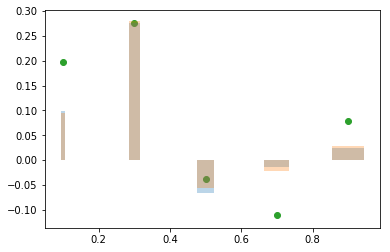

In [42]:
plt.bar(bins,ints,bins*0.1,alpha=0.3)
plt.bar(bins,simple_ints,bins*0.1,alpha=0.3)
plt.scatter(bins,thin_kernel(bins,bins+0.2))

**Load power spectra and rebin**

In [64]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # jaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

**Rebin estimate**

In [86]:
binfile = '/mnt/store1/oliverphilcox/PowerSpectra/k_binning.csv'
k_bins = np.loadtxt(binfile)

binned_power = []
true_binned_power = []

for i in range(len(k_bins)):
    binned_power.append(quad(lambda k: kaiser_power_model(k,2)*k,k_bins[i,0],k_bins[i,1])[0]/quad(lambda k: k,k_bins[i,0],k_bins[i,1])[0])
    true_binned_power.append(quad(lambda k: kaiser_power_model(k,2)*k**2.,k_bins[i,0],k_bins[i,1])[0]/quad(lambda k: k**2.,k_bins[i,0],k_bins[i,1])[0])

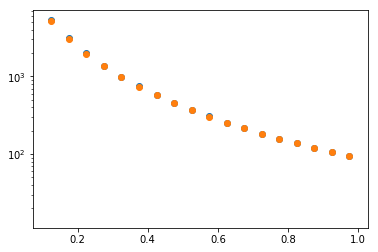

In [91]:
plt.scatter(np.mean(k_bins,axis=1),binned_power)
plt.scatter(np.mean(k_bins,axis=1),true_binned_power)
plt.yscale('log');

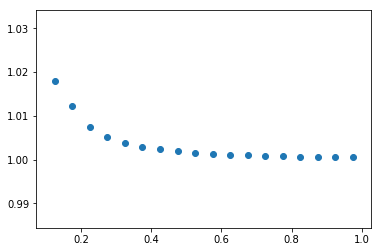

In [92]:
plt.scatter(np.mean(k_bins,axis=1),np.asarray(binned_power)/np.asarray(true_binned_power))

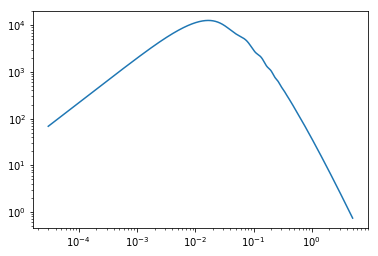

In [67]:
plt.loglog(kh,pk)